#Linear Regression

Simple linear regression with 1 variable 

The data : Gender, Height (inch), weight (lbs)

In [ ]:
!wget https://gist.githubusercontent.com/nstokoe/7d4717e96c21b8ad04ec91f361b000cb/raw/bf95a2e30fceb9f2ae990eac8379fc7d844a0196/weight-height.csv

--2022-01-31 09:52:26--  https://gist.githubusercontent.com/nstokoe/7d4717e96c21b8ad04ec91f361b000cb/raw/bf95a2e30fceb9f2ae990eac8379fc7d844a0196/weight-height.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418120 (408K) [text/plain]
Saving to: ‘weight-height.csv’

weight-height.csv   100%[===================>] 408.32K  --.-KB/s    in 0.04s   

2022-01-31 09:52:26 (11.4 MB/s) - ‘weight-height.csv’ saved [418120/418120]



In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 29 kB/s 
     |████████████████████████████████| 198 kB 56.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=84f2f13eb1b4bdb77e1b48872a035f0b0c942f34d83632826ea03540ea11b878
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MlLib - Machine Learning').getOrCreate()

In [ ]:
df = spark.read.csv(path='weight-height.csv', sep=',', header = True, inferSchema = True)

In [ ]:
df.printSchema()
df.show(5)
df.describe().show()

root
 |-- Gender: string (nullable = true)
 |-- Height: double (nullable = true)
 |-- Weight: double (nullable = true)

+------+----------------+----------------+
|Gender|          Height|          Weight|
+------+----------------+----------------+
|  Male| 73.847017017515|241.893563180437|
|  Male|68.7819040458903|  162.3104725213|
|  Male|74.1101053917849|  212.7408555565|
|  Male|71.7309784033377|220.042470303077|
|  Male|69.8817958611153|206.349800623871|
+------+----------------+----------------+
only showing top 5 rows

+-------+------+-----------------+------------------+
|summary|Gender|           Height|            Weight|
+-------+------+-----------------+------------------+
|  count| 10000|            10000|             10000|
|   mean|  null|66.36755975482106|161.44035683283076|
| stddev|  null|3.847528120773333|32.108439006519674|
|    min|Female| 54.2631333250971|   64.700126712753|
|    max|  Male| 78.9987423463896|  269.989698505106|
+-------+------+-----------------+--

First we plot the data with `scatterplot`. Since the data is quite big, we will sample 100 data point randomly using dataframe's `sample` function.

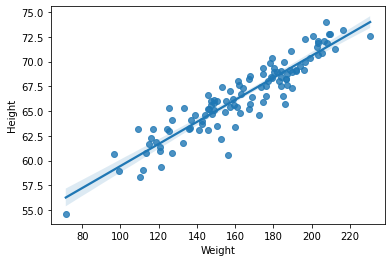

In [ ]:
import seaborn as sns
import pandas as pd

sample = df.sample(fraction=.01)
pdf = sample.toPandas()

sns.regplot(x='Weight', y='Height', data=pdf)
#sns.scatterplot(x='Weight', y='Height', data=pdf)

In [ ]:
training = df.select(["Weight", "Height"])
training.show(5)

+----------------+----------------+
|          Weight|          Height|
+----------------+----------------+
|241.893563180437| 73.847017017515|
|  162.3104725213|68.7819040458903|
|  212.7408555565|74.1101053917849|
|220.042470303077|71.7309784033377|
|206.349800623871|69.8817958611153|
+----------------+----------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col

features = ['Weight']
label = 'Height'

df_selected = df.select(*features, col(label).alias("label"))
(training, test) = df_selected.randomSplit([.7, .3])

In [ ]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols=features, outputCol="features")
training = vectorAssembler.transform(training)
training.show(5, False)

+----------------+----------------+------------------+
|Weight          |label           |features          |
+----------------+----------------+------------------+
|68.9825300912419|55.6682021205121|[68.9825300912419]|
|78.6066703120237|54.8737275315254|[78.6066703120237]|
|79.1743758333647|56.7644564465812|[79.1743758333647]|
|82.1984878532933|60.336579370944 |[82.1984878532933]|
|83.9930774713752|56.7854343692644|[83.9930774713752]|
+----------------+----------------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show(5)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.10174441835721482]
Intercept: 49.96962463556726
numIterations: 2
objectiveHistory: [0.5, 0.4205406654467074, 0.1346620112875879]


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-------------------+
|          residuals|
+-------------------+
|-1.3200099159976375|
|-3.0936870539360584|
|-1.2607190069472765|
| 2.0037173989008323|
|-1.7300170796604064|
+-------------------+
only showing top 5 rows

RMSE: 1.493986
r2: 0.848133


In [ ]:
#prediction
test = vectorAssembler.transform(test)
predictions = lrModel.transform(test)

# Select example rows to display.
print("\nModel Prediction Result :  ")
predictions.select("features","label","prediction").show(5)


Model Prediction Result :  
+------------------+----------------+------------------+
|          features|           label|        prediction|
+------------------+----------------+------------------+
| [64.700126712753]|54.2631333250971|56.552501395594405|
| [71.393748738973]|54.6168578301035| 57.23354007535521|
|[72.7501446905149]| 57.353092760465|57.371545792506915|
|[77.5237739030693]|58.2116499335358| 57.85723592019127|
|[77.8985592718359]|56.1672991862273| 57.89536823954522|
+------------------+----------------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Select (prediction, true label) and compute test error
evaluator1 = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="rmse")
rmse1 = evaluator1.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse1)

evaluator2 = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="r2")
r21 = evaluator2.evaluate(predictions)
print("R-Squared on test data = %g" % r21)


Root Mean Squared Error (RMSE) on test data = 1.49096
R-Squared on test data = 0.852181


We can consider other variable (in this case 'Gender') as additional input variable to predict height. First let's plot the data. 
We will use the same sample data we took from before.

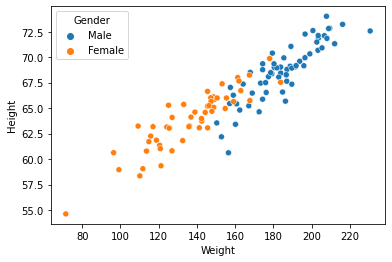

In [ ]:
sns.scatterplot(x="Weight", y="Height", hue="Gender", data=pdf)

Split the data into training-test set

In [ ]:
features = ['Weight', 'Gender']
label = 'Height'

(training_, test_) = df.randomSplit([.7, .3])

Since Gender is a categorical variable, we need to transform it to numeric using `StringIndexer` and `OneHotEncoder` 

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col

indexer = StringIndexer(inputCol="Gender", outputCol="Gender_idx")

# default setting: dropLast=True
encoder = OneHotEncoder(inputCol="Gender_idx",
      outputCol="Gender_encoded".format(indexer.getOutputCol()))

assembler = VectorAssembler(inputCols=["Weight", "Gender_encoded"], outputCol="features")

pipeline = Pipeline(stages=[indexer, encoder, assembler])
model = pipeline.fit(training_)
output = model.transform(training_)

output.show(5)

training = output.select("features", col(label).alias("label"))
training.show(5)

+------+----------------+----------------+----------+--------------+--------------------+
|Gender|          Height|          Weight|Gender_idx|Gender_encoded|            features|
+------+----------------+----------------+----------+--------------+--------------------+
|Female|54.2631333250971| 64.700126712753|       0.0| (1,[0],[1.0])|[64.700126712753,...|
|Female|54.8737275315254|78.6066703120237|       0.0| (1,[0],[1.0])|[78.6066703120237...|
|Female|55.1485573624105| 88.812412112758|       0.0| (1,[0],[1.0])|[88.812412112758,...|
|Female| 55.336492408949|88.3665825783999|       0.0| (1,[0],[1.0])|[88.3665825783999...|
|Female|55.6518916024929|85.6217764414627|       0.0| (1,[0],[1.0])|[85.6217764414627...|
+------+----------------+----------------+----------+--------------+--------------------+
only showing top 5 rows

+--------------------+----------------+
|            features|           label|
+--------------------+----------------+
|[64.700126712753,...|54.2631333250971|
|[78.

In [ ]:
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show(5)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.10186996670284709,0.0]
Intercept: 49.91549660411871
numIterations: 10
objectiveHistory: [0.5, 0.4047535901854327, 0.16732460531638393, 0.15826784229312993, 0.13792524966955136, 0.1334614826150452, 0.13311838564438283, 0.13309893171236242, 0.13309782865548567, 0.1330977661110976, 0.13309776256475392]


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-------------------+
|          residuals|
+-------------------+
|-2.2433630329197456|
|-3.0494279599008465|
|-3.8142567064343993|
| -3.580905020075697|
|-2.9858925167562305|
+-------------------+
only showing top 5 rows

RMSE: 1.487587
r2: 0.850950


In [ ]:
#prediction
output = model.transform(test_)
test = output.select("features", col(label).alias("label"))
test.show(5, truncate=False)


predictions = lrModel.transform(test)

# Select example rows to display.
print("\nModel Prediction Result :  ")
predictions.select("features","label","prediction").show(5)

+----------------------+----------------+
|features              |label           |
+----------------------+----------------+
|[71.393748738973,1.0] |54.6168578301035|
|[104.954100411731,1.0]|56.098245784398 |
|[80.5312593808895,1.0]|56.108902096181 |
|[77.8985592718359,1.0]|56.1672991862273|
|[97.7438964834685,1.0]|56.5341658080891|
+----------------------+----------------+
only showing top 5 rows


Model Prediction Result :  
+--------------------+----------------+------------------+
|            features|           label|        prediction|
+--------------------+----------------+------------------+
|[71.393748738973,...|54.6168578301035| 57.18837541094932|
|[104.954100411731...| 56.098245784398| 60.60716731838902|
|[80.5312593808895...| 56.108902096181|58.119213315788265|
|[77.8985592718359...|56.1672991862273| 57.85102024334039|
|[97.7438964834685...|56.5341658080891|59.872664084296176|
+--------------------+----------------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Select (prediction, true label) and compute test error
evaluator1 = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="rmse")
rmse1 = evaluator1.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse1)

evaluator2 = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="r2")
r21 = evaluator2.evaluate(predictions)
print("R-Squared on test data = %g" % r21)


Root Mean Squared Error (RMSE) on test data = 1.50256
R-Squared on test data = 0.846371


#Simple Binary Logistic Regression

logistic regression with 1 variable : Weight - gender
This time we will use the variable `Weight` to predict the variable `Gender` 

First we will plot 

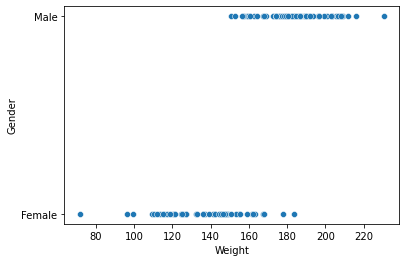

In [ ]:
sns.scatterplot(x='Weight', y='Gender', data=pdf)

Since logistic regression requires all variable (input and target) in numeric format, we will transform the target variable `Gender` into numeric using `StringIndexer`. We then split the dataset into training-test set with 70:30 ratio.

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

features = ['Weight']
label = 'Gender'

indexer = StringIndexer(inputCol=label, outputCol="label".format(label))
indexer = indexer.fit(df)
df_indexed = indexer.transform(df)

df_selected = df_indexed.select(*features, 'label')
(training, test) = df_selected.randomSplit([.7, .3])

training.show(5)

+----------------+-----+
|          Weight|label|
+----------------+-----+
| 64.700126712753|  0.0|
|68.9825300912419|  0.0|
| 71.393748738973|  0.0|
|72.7501446905149|  0.0|
|77.5237739030693|  0.0|
+----------------+-----+
only showing top 5 rows



Let's sample and plot the data again

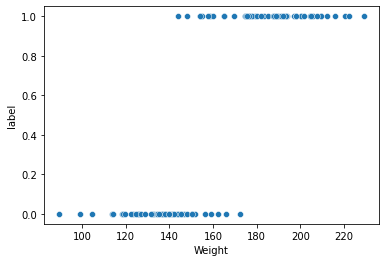

In [ ]:
sample = df_selected.sample(fraction=.01)
pdf = sample.toPandas()

sns.scatterplot(x='Weight', y='label', data=pdf)

In [ ]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols=features, outputCol="features")
training = vectorAssembler.transform(training)
training.show(5, False)

+----------------+-----+------------------+
|Weight          |label|features          |
+----------------+-----+------------------+
|64.700126712753 |0.0  |[64.700126712753] |
|68.9825300912419|0.0  |[68.9825300912419]|
|71.393748738973 |0.0  |[71.393748738973] |
|72.7501446905149|0.0  |[72.7501446905149]|
|77.5237739030693|0.0  |[77.5237739030693]|
+----------------+-----+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression() #(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))


Coefficients: [0.13776616624298701]
Intercept: -22.216316493382855


In [ ]:
#code from :  https://spark.apache.org/docs/latest/ml-classification-regression.html#binomial-logistic-regression 

from pyspark.ml.classification import LogisticRegression

# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = lrModel.summary

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
    
lr.setThreshold(bestThreshold)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0|0.001741654571843...|
|0.0|0.003483309143686...|
|0.0|0.005224963715529...|
|0.0|0.006966618287373005|
+---+--------------------+
only showing top 5 rows

areaUnderROC: 0.9690450707920795


LogisticRegression_684be1116be7

Make prediction using test set 

In [ ]:
#prediction
test1 = vectorAssembler.transform(test)
predictions = lrModel.transform(test1)

# Select example rows to display.
print("\nModel Prediction Result :  ")
predictions.select("features","label","prediction").show(5)


Model Prediction Result :  
+------------------+-----+----------+
|          features|label|prediction|
+------------------+-----+----------+
|[84.1706947685606]|  0.0|       0.0|
|[85.4175336162677]|  0.0|       0.0|
|[86.0590456033491]|  0.0|       0.0|
|[86.8907118416325]|  0.0|       0.0|
|[87.0354160033182]|  0.0|       0.0|
+------------------+-----+----------+
only showing top 5 rows



Let's construct confusion matrix from prediction result

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix


array([[1367,  137],
       [ 143, 1412]])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

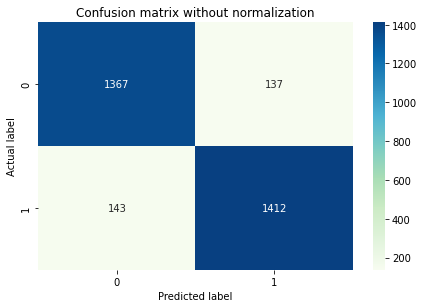

In [ ]:
class_names=[0,1] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="GnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix without normalization', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()

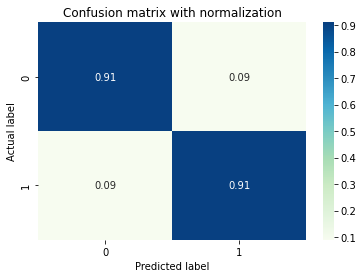

In [ ]:
cnf_norm = []
for i in cnf_matrix:
  total = sum(i)
  t = []
  for j in i:
    t = t + [round(j/total,2)]
  cnf_norm = cnf_norm + [t]

sns.heatmap(pd.DataFrame(cnf_norm), annot=True, cmap="GnBu" ,fmt='g')
plt.title('Confusion matrix with normalization', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

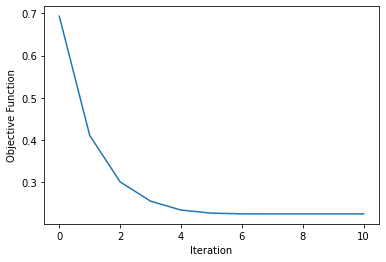

In [ ]:
#Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

areaUnderROC: 0.9690450707920795


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


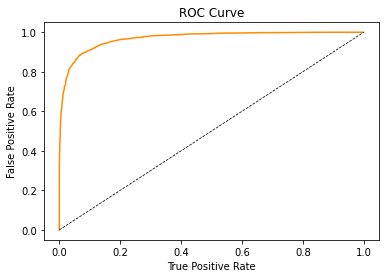

In [ ]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

#trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'], color = 'darkorange', label='ROC curve (area = %0.2f)' % trainingSummary.areaUnderROC)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], color='black', lw=.75, linestyle='--')
plt.show()
